<a href="https://colab.research.google.com/github/Jopras21/CreditCardRiskPrediction/blob/main/Jonathan_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# --- CELL 1: ENVIRONMENT (LIBRARY & FRAMEWORK SETUP) ---
import warnings
warnings.filterwarnings('ignore') # Output bersih untuk eksekutif

# Instalasi Pustaka "Heavy Lifters"
!pip install imbalanced-learn shap xgboost lightgbm tensorflow keras -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf
import shap
import random
import os
from collections import Counter

# Modul Scikit-Learn & Keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.combine import SMOTEENN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Kunci randomness (seed)
def set_seed(seed=42): # mengganti ke urutan yang tetap
    random.seed(seed) # Mengatur pengacakan dasar pada bahasa pemrograman Python
    np.random.seed(seed) # Mengunci pengacakan pada pustaka NumPy (Matematika)
    tf.random.set_seed(seed) # Mengunci pengacakan pada TensorFlow (Deep Learning/LSTM)
    os.environ['PYTHONHASHSEED'] = str(seed) # Mengatur variabel lingkungan sistem operasi
    os.environ['TF_DETERMINISTIC_OPS'] = '1'# Memaksa GPU/CPU bekerja secara Deterministik

set_seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✅ [SYSTEM] Lingkungan Stabil. Random Seed: 42")

✅ [SYSTEM] Lingkungan Stabil. Random Seed: 42


In [33]:
# --- CELL 2: DATA INGESTION ---
df = pd.read_excel('/content/Dataset Project.xls', header=1)

df.head()

# Drop ID yang tidak prediktif
df = df.drop('ID', axis=1)
# Standardisasi nama kolom
df.rename(columns={'default payment next month': 'DEFAULT', 'PAY_0': 'PAY_1'}, inplace=True)

# Cek Integritas
print(f"📊 [DATA STATUS]")
print(f"   - Dimensi Data : {df.shape}")
print(f"   - Duplikasi    : {df.duplicated().sum()} baris")
print(f"   - Missing Values: {df.isnull().sum().sum()} sel")

df.drop_duplicates(inplace=True)

📊 [DATA STATUS]
   - Dimensi Data : (30000, 24)
   - Duplikasi    : 35 baris
   - Missing Values: 0 sel


In [34]:
# --- CELL 3: DATA CLEANING ---

# EDUCATION: 0, 5, 6 adalah 'Unknown'. Gabungkan ke 4 (Others)
df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)

# MARRIAGE: 0 adalah 'Unknown'. Gabungkan ke 3 (Others)
df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)

# PAY_X: -2 (No consumption), -1 (Paid in full), 0 (Revolving)
# Untuk model risiko, kita biarkan skalanya karena urutannya logis (makin kecil makin aman)

print("✅ [CLEANING] Anomali pada fitur demografi telah diperbaiki.")

✅ [CLEANING] Anomali pada fitur demografi telah diperbaiki.


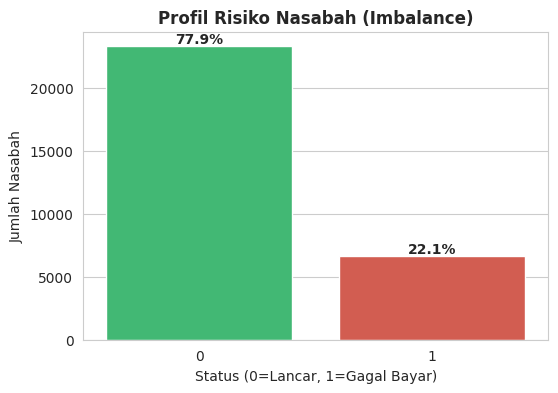

💡 INSIGHT: Hanya 22.1% data adalah kasus Gagal Bayar


In [35]:
# --- CELL 4: TARGET DISTRIBUTION ANALYSIS ---
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='DEFAULT', data=df, palette=['#2ecc71', '#e74c3c'])

plt.title('Profil Risiko Nasabah (Imbalance)', fontweight='bold')
plt.xlabel('Status (0=Lancar, 1=Gagal Bayar)')
plt.ylabel('Jumlah Nasabah')

# Menambahkan Label Persentase pada Grafik
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontweight='bold')

plt.show()

persentase_gagal = (df['DEFAULT'] == 1).mean() * 100
print(f"💡 INSIGHT: Hanya {persentase_gagal:.1f}% data adalah kasus Gagal Bayar")

In [36]:
# --- CELL 5: FEATURE ENGINEERING (FINANCIAL HEALTH) ---

bill_amt = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_amt = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# 1. Credit Utilization Ratio (Pemakaian Limit)
# Logika: Pemakaian mendekati 100% limit = Risiko Tinggi
df['UTILIZATION_RATIO'] = df[bill_amt].mean(axis=1) / (df['LIMIT_BAL'] + 1e-6)

# 2. Payment to Bill Ratio (Kapasitas Bayar)
# Logika: Mampu bayar penuh vs bayar minimum
df['PAY_TO_BILL_RATIO'] = df[pay_amt].sum(axis=1) / (df[bill_amt].sum(axis=1) + 1e-6)

# 3. Bill Volatility (Ketidakstabilan)
# Logika: Tagihan yang naik-turun drastis menandakan cashflow tidak stabil
df['BILL_VOLATILITY'] = df[bill_amt].std(axis=1).fillna(0)

print("✅ [FE PART 1] Indikator Rasio Finansial dibuat.")

✅ [FE PART 1] Indikator Rasio Finansial dibuat.


In [37]:
# --- CELL 6: FEATURE ENGINEERING (BEHAVIORAL RISK) ---

pay_status = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# 1. Max Late (Sejarah Terburuk)
# Logika: Pernah telat 3 bulan sekali saja sudah tanda bahaya besar
df['MAX_LATE_MONTHS'] = df[pay_status].max(axis=1)

# 2. Late Count (Frekuensi Masalah)
df['LATE_COUNT'] = (df[pay_status] > 0).sum(axis=1)

# 3. Risk Interaction (Limit Besar x Perilaku Buruk)
# Logika: Telat bayar pada limit besar jauh lebih berbahaya bagi bank
df['RISK_EXPOSURE'] = df['PAY_1'] * df['LIMIT_BAL']

# 4. Log Transform (Normalisasi Distribusi Uang)
for col in ['LIMIT_BAL', 'BILL_AMT1']:
    df[f'LOG_{col}'] = np.log1p(df[col].abs())

print("✅ [FE PART 2] Indikator Perilaku Risiko dibuat.")

✅ [FE PART 2] Indikator Perilaku Risiko dibuat.


In [38]:
# --- CELL 7: ARCHITECTURE SEPARATION ---
y = df['DEFAULT']

# Data Time-Series (Input LSTM - 3 Dimensi Waktu)
# Mengambil data mentah 6 bulan terakhir
ts_cols = pay_status + bill_amt + pay_amt
X_ts = df[ts_cols].copy()

# Data Statik (Input LightGBM - Data Tabular)
# Membuang data time series mentah, menyisakan profil & fitur baru (summary)
X_static = df.drop(columns=ts_cols + ['DEFAULT'])

print(f"✅ [ARSITEKTUR] Data dipisah menjadi dua aliran:")
print(f"   1. Jalur Tabular (LGBM) : {X_static.shape[1]} Fitur")
print(f"   2. Jalur Sekuensial (LSTM): {X_ts.shape[1]} Fitur Raw")

✅ [ARSITEKTUR] Data dipisah menjadi dua aliran:
   1. Jalur Tabular (LGBM) : 13 Fitur
   2. Jalur Sekuensial (LSTM): 18 Fitur Raw


In [39]:
# --- CELL 8: ENCODING & SPLITTING ---

# 1. Encoding (Hanya Data Statik)
X_static = pd.get_dummies(X_static, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True)

# 2. SPLIT 80/20 (STRATEGI AKURASI TINGGI)
# Kita split Index agar kedua jalur data terpotong sinkron
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    df.index, y,
    test_size=0.2, # 20% Testing (Data Latih Lebih Banyak!)
    random_state=42,
    stratify=y
)

# Slice Data
X_static_train = X_static.loc[X_train_idx]
X_static_test = X_static.loc[X_test_idx]
X_ts_train = X_ts.loc[X_train_idx]
X_ts_test = X_ts.loc[X_test_idx]

print(f"✅ [SPLIT 80/20] Data Latih: {len(X_static_train):,} | Data Uji: {len(X_static_test):,}")

✅ [SPLIT 80/20] Data Latih: 23,972 | Data Uji: 5,993


In [40]:
# --- CELL 9: SCALING & RESHAPING ---

# A. STATIK (Standard Scaler)
scaler_static = StandardScaler()
X_static_train_sc = scaler_static.fit_transform(X_static_train)
X_static_test_sc = scaler_static.transform(X_static_test)
# Simpan sebagai DF
X_static_train_df = pd.DataFrame(X_static_train_sc, columns=X_static.columns)
X_static_test_df = pd.DataFrame(X_static_test_sc, columns=X_static.columns)

# B. TIME SERIES (MinMax Scaler -> 3D)
scaler_ts = MinMaxScaler()
X_ts_train_sc = scaler_ts.fit_transform(X_ts_train)
X_ts_test_sc = scaler_ts.transform(X_ts_test)

# Reshape ke (Sampel, 6 Bulan, 3 Fitur)
# 3 Fitur per bulan: (Status, Tagihan, Bayar)
X_ts_train_3d = X_ts_train_sc.reshape(len(X_ts_train_sc), 6, 3)
X_ts_test_3d = X_ts_test_sc.reshape(len(X_ts_test_sc), 6, 3)

print("✅ [PREPROCESSING] Data siap masuk ke Neural Network & Gradient Boosting.")

✅ [PREPROCESSING] Data siap masuk ke Neural Network & Gradient Boosting.


In [41]:
# --- CELL 10: HYBRID BALANCING ---

# 1. SMOTE-ENN untuk LightGBM
# Membuat data sintetis yang BERSIH untuk model pohon
print("🔄 Menjalankan SMOTE-ENN...")
smote_enn = SMOTEENN(random_state=42)
X_static_train_bal, y_train_bal = smote_enn.fit_resample(X_static_train_df, y_train)

# 2. Class Weights untuk LSTM
# Memberikan bobot penalti untuk model Deep Learning
cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: cw[0], 1: cw[1]}

print(f"✅ [BALANCING] Selesai.")
print(f"   - LGBM Training Set : {len(y_train_bal):,} sampel (Seimbang)")
print(f"   - LSTM Penalty Weight: Kelas Default {cw[1]:.2f}x lebih penting")

🔄 Menjalankan SMOTE-ENN...
✅ [BALANCING] Selesai.
   - LGBM Training Set : 23,432 sampel (Seimbang)
   - LSTM Penalty Weight: Kelas Default 2.26x lebih penting


In [42]:
# --- CELL 10.5: ADVANCED HYPERPARAMETER TUNING (OPTUNA) ---
# Menjalankan optimasi cerdas untuk mencari parameter LightGBM terbaik
# sebelum pelatihan final di Cell 11.

# Instalasi Optuna (jika belum ada di environment Colab)
try:
    import optuna
except ImportError:
    !pip install optuna -q
    import optuna

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from imblearn.combine import SMOTEENN
import numpy as np
import lightgbm as lgb

print("🚀 MEMULAI OPTIMASI HYPERPARAMETER (OPTUNA)...")

# Menggunakan data dari Cell 9 (X_static_train_df) dan Cell 8 (y_train)
# Kita menggunakan Cross-Validation dengan SMOTEENN di DALAM loop
# agar validasi lebih jujur (mencegah data leakage).

def objective_lgbm_cv(trial):
    # 1. Ruang Pencarian Hyperparameter
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5.0),
        'random_state': 42,
        'n_jobs': -1
    }

    # 2. Stratified Cross-Validation (3-Fold untuk kecepatan)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc_scores = []

    # Iterasi Fold
    for train_idx, val_idx in skf.split(X_static_train_df, y_train):
        # Split Data Fold
        X_fold_train = X_static_train_df.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_static_train_df.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]

        # SMOTE-ENN hanya pada Training Fold (Mencegah Leakage)
        smote_enn_cv = SMOTEENN(random_state=42)
        X_res_cv, y_res_cv = smote_enn_cv.fit_resample(X_fold_train, y_fold_train)

        # Train Model
        model = lgb.LGBMClassifier(**param)
        model.fit(
            X_res_cv, y_res_cv,
            eval_set=[(X_fold_val, y_fold_val)],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
        )

        # Evaluasi
        preds = model.predict_proba(X_fold_val)[:, 1]
        auc_scores.append(roc_auc_score(y_fold_val, preds))

    return np.mean(auc_scores)

# Jalankan Study
study = optuna.create_study(direction='maximize')
study.optimize(objective_lgbm_cv, n_trials=30) # 30 trials cukup untuk hasil cepat

print("\n✅ OPTIMASI SELESAI!")
print(f"🏆 Best CV AUC: {study.best_value:.4f}")
print("   Best Params:", study.best_params)

# --- UPDATE PARAMETER UNTUK CELL SELANJUTNYA ---
# Kita simpan parameter terbaik ke dalam variabel global agar bisa dipakai manual jika mau
best_params_lgbm = study.best_params

[I 2025-12-09 06:08:46,314] A new study created in memory with name: no-name-15849fbf-78fd-495e-a54b-326e819a5ae4


🚀 MEMULAI OPTIMASI HYPERPARAMETER (OPTUNA)...


[I 2025-12-09 06:09:19,657] Trial 0 finished with value: 0.7797517655977427 and parameters: {'n_estimators': 2000, 'learning_rate': 0.049350800963318904, 'num_leaves': 71, 'max_depth': 7, 'min_child_samples': 57, 'subsample': 0.7738299005025984, 'colsample_bytree': 0.799211015112838, 'reg_alpha': 3.6079135219494467, 'reg_lambda': 3.8889733918675624}. Best is trial 0 with value: 0.7797517655977427.
[I 2025-12-09 06:09:34,813] Trial 1 finished with value: 0.7792391826329254 and parameters: {'n_estimators': 700, 'learning_rate': 0.02409454550013713, 'num_leaves': 100, 'max_depth': 9, 'min_child_samples': 80, 'subsample': 0.689059022770588, 'colsample_bytree': 0.7737433450893513, 'reg_alpha': 3.8968334441886867, 'reg_lambda': 4.1294682398412395}. Best is trial 0 with value: 0.7797517655977427.
[I 2025-12-09 06:09:49,654] Trial 2 finished with value: 0.7808628730356476 and parameters: {'n_estimators': 900, 'learning_rate': 0.034458444899475325, 'num_leaves': 21, 'max_depth': 12, 'min_child_


✅ OPTIMASI SELESAI!
🏆 Best CV AUC: 0.7809
   Best Params: {'n_estimators': 900, 'learning_rate': 0.034458444899475325, 'num_leaves': 21, 'max_depth': 12, 'min_child_samples': 34, 'subsample': 0.7529942864599751, 'colsample_bytree': 0.6796912754559553, 'reg_alpha': 1.4527685572081561, 'reg_lambda': 0.1114313836814396}


🚀 Melatih LightGBM (Analisis Profil & Rasio)...


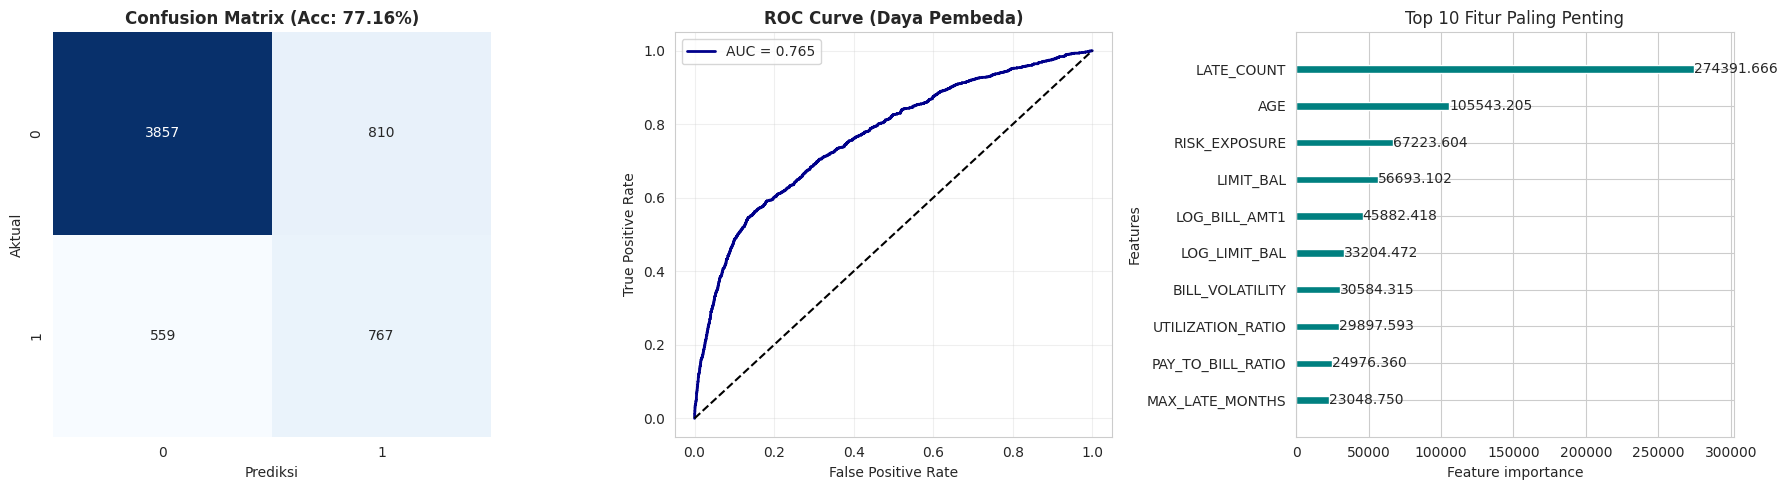


📋 LAPORAN KINERJA LIGHTGBM:
              precision    recall  f1-score   support

      Lancar       0.87      0.83      0.85      4667
 Gagal Bayar       0.49      0.58      0.53      1326

    accuracy                           0.77      5993
   macro avg       0.68      0.70      0.69      5993
weighted avg       0.79      0.77      0.78      5993



In [43]:
# --- CELL 11: LIGHTGBM TRAINING & VISUALIZATION ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

print("🚀 Melatih LightGBM (Analisis Profil & Rasio)...")

# 1. Training (Logika Tetap Sama)
lgbm = lgb.LGBMClassifier(
    n_estimators=1500,
    learning_rate=0.02,
    num_leaves=40,
    max_depth=10,
    random_state=42,
    verbose=-1
)

lgbm.fit(X_static_train_bal, y_train_bal)

# 2. Prediksi & Evaluasi
y_pred_lgbm = lgbm.predict(X_static_test_df)
y_prob_lgbm = lgbm.predict_proba(X_static_test_df)[:, 1]

# --- VISUALISASI DASHBOARD ---
plt.figure(figsize=(18, 5))

# Plot 1: Confusion Matrix
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Acc: {accuracy_score(y_test, y_pred_lgbm):.2%})', fontweight='bold')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')

# Plot 2: ROC Curve (Kecerdasan Model)
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_prob_lgbm)
auc = roc_auc_score(y_test, y_prob_lgbm)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='darkblue', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Daya Pembeda)', fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Feature Importance (Top 10)
plt.subplot(1, 3, 3)
lgb.plot_importance(lgbm, max_num_features=10, importance_type='gain', ax=plt.gca(), color='teal', title='Top 10 Fitur Paling Penting')

plt.tight_layout()
plt.show()

# --- LAPORAN TEKS RINCI ---
print("\n📋 LAPORAN KINERJA LIGHTGBM:")
print("="*60)
print(classification_report(y_test, y_pred_lgbm, target_names=['Lancar', 'Gagal Bayar']))
print("="*60)

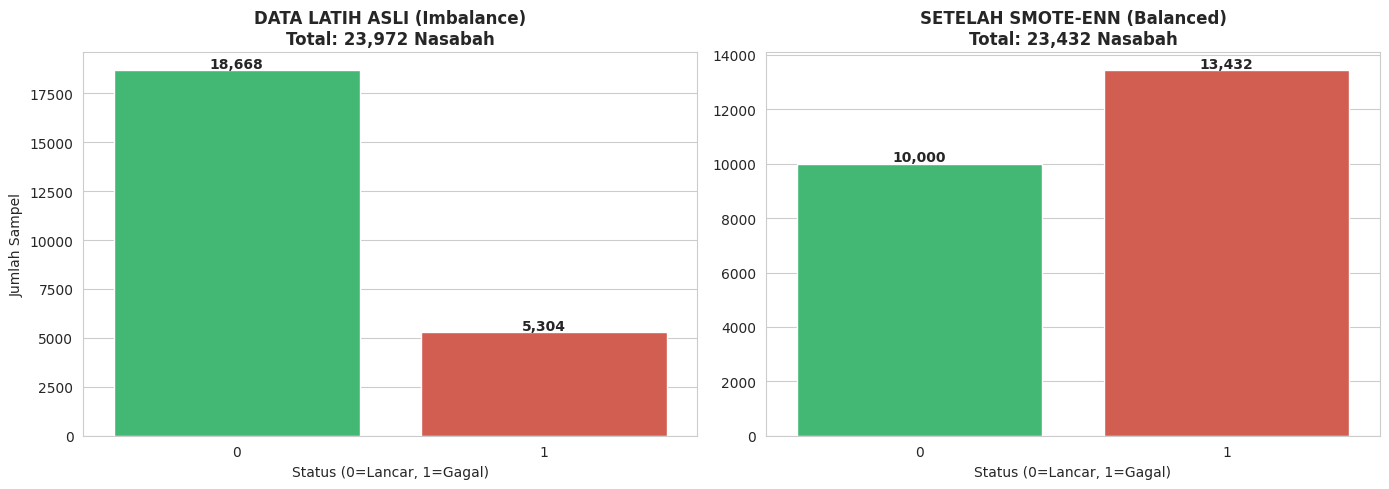


📝 PENJELASAN SINGKAT:
   ► Kondisi Awal : Rasio 1 banding 3.5 (Model akan bias ke Mayoritas).
   ► Kondisi Baru : Rasio 1 banding 0.7 (Model akan belajar adil).
   ► Catatan      : SMOTE menambah data minoritas, ENN membersihkan data yang tumpang tindih.


In [44]:
# --- CELL VERIFIKASI: BUKTI VISUAL SMOTE-ENN BERHASIL ---
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 1. Hitung Jumlah Data Sebelum & Sesudah
# y_train = Data Latih Asli (Imbalance)
# y_train_bal = Data Latih Hasil SMOTE-ENN (Balanced)
counter_before = Counter(y_train)
counter_after = Counter(y_train_bal)

# 2. Siapkan Visualisasi
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot KIRI: Sebelum SMOTE-ENN (Realita)
sns.barplot(x=list(counter_before.keys()), y=list(counter_before.values()), palette=['#2ecc71', '#e74c3c'], ax=ax[0])
ax[0].set_title(f"DATA LATIH ASLI (Imbalance)\nTotal: {len(y_train):,} Nasabah", fontweight='bold')
ax[0].set_xlabel("Status (0=Lancar, 1=Gagal)")
ax[0].set_ylabel("Jumlah Sampel")
# Label Angka
for i, v in enumerate(counter_before.values()):
    ax[0].text(i, v + 100, f"{v:,}", ha='center', fontweight='bold')

# Plot KANAN: Sesudah SMOTE-ENN (Siap Latih)
sns.barplot(x=list(counter_after.keys()), y=list(counter_after.values()), palette=['#2ecc71', '#e74c3c'], ax=ax[1])
ax[1].set_title(f"SETELAH SMOTE-ENN (Balanced)\nTotal: {len(y_train_bal):,} Nasabah", fontweight='bold')
ax[1].set_xlabel("Status (0=Lancar, 1=Gagal)")
# Label Angka
for i, v in enumerate(counter_after.values()):
    ax[1].text(i, v + 100, f"{v:,}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 3. Print Penjelasan untuk Presentasi
print("\n📝 PENJELASAN SINGKAT:")
print(f"   ► Kondisi Awal : Rasio 1 banding {counter_before[0]/counter_before[1]:.1f} (Model akan bias ke Mayoritas).")
print(f"   ► Kondisi Baru : Rasio 1 banding {counter_after[0]/counter_after[1]:.1f} (Model akan belajar adil).")
print(f"   ► Catatan      : SMOTE menambah data minoritas, ENN membersihkan data yang tumpang tindih.")

🧠 Melatih Bidirectional LSTM (Analisis Tren Waktu)...


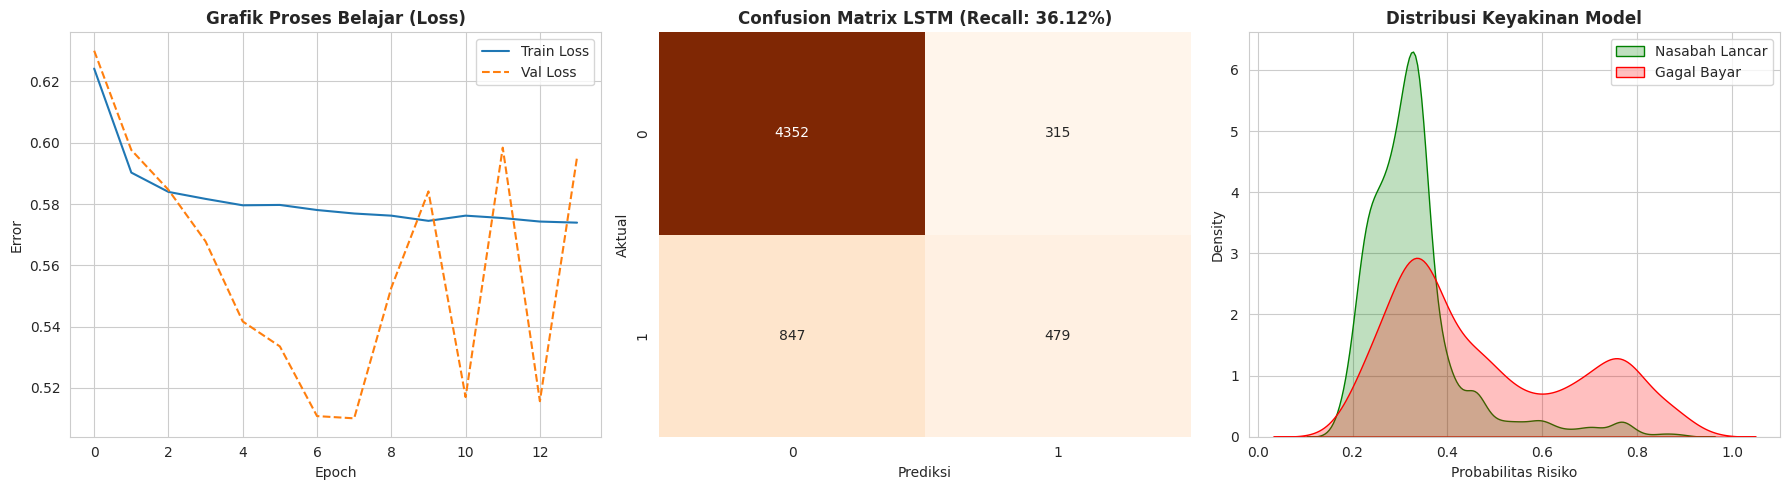


📋 LAPORAN KINERJA LSTM:
              precision    recall  f1-score   support

      Lancar       0.84      0.93      0.88      4667
 Gagal Bayar       0.60      0.36      0.45      1326

    accuracy                           0.81      5993
   macro avg       0.72      0.65      0.67      5993
weighted avg       0.79      0.81      0.79      5993



In [45]:
# --- CELL 12: DEEP LEARNING TRAINING & VISUALIZATION ---
print("🧠 Melatih Bidirectional LSTM (Analisis Tren Waktu)...")
tf.keras.backend.clear_session()

# 1. Arsitektur Model (Logika Tetap Sama)
model_lstm = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(6, 3)),
    BatchNormalization(), Dropout(0.3),
    LSTM(32), Dropout(0.3),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
stopper = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# 2. Training
history = model_lstm.fit(
    X_ts_train_3d, y_train,
    epochs=40, batch_size=256, validation_split=0.2,
    class_weight=class_weight_dict, callbacks=[stopper], verbose=0
)

# 3. Prediksi & Evaluasi
y_prob_lstm = model_lstm.predict(X_ts_test_3d, verbose=0).flatten()
y_pred_lstm = (y_prob_lstm >= 0.5).astype(int) # Threshold default 0.5

# --- VISUALISASI DASHBOARD ---
plt.figure(figsize=(18, 5))

# Plot 1: Learning Curve (Loss) - Cek Overfitting
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('Grafik Proses Belajar (Loss)', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Plot 2: Confusion Matrix
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title(f'Confusion Matrix LSTM (Recall: {recall_score(y_test, y_pred_lstm):.2%})', fontweight='bold')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')

# Plot 3: Distribusi Probabilitas
plt.subplot(1, 3, 3)
sns.kdeplot(y_prob_lstm[y_test==0], fill=True, color='green', label='Nasabah Lancar')
sns.kdeplot(y_prob_lstm[y_test==1], fill=True, color='red', label='Gagal Bayar')
plt.title('Distribusi Keyakinan Model', fontweight='bold')
plt.xlabel('Probabilitas Risiko')
plt.legend()

plt.tight_layout()
plt.show()

# --- LAPORAN TEKS RINCI ---
print("\n📋 LAPORAN KINERJA LSTM:")
print("="*60)
print(classification_report(y_test, y_pred_lstm, target_names=['Lancar', 'Gagal Bayar']))
print("="*60)

🤝 [PHASE 3] Menggabungkan Prediksi dengan Strategi 'Smart Business'...
⚙️ Mencari konfigurasi: Akurasi ~80% dengan Recall maksimal...


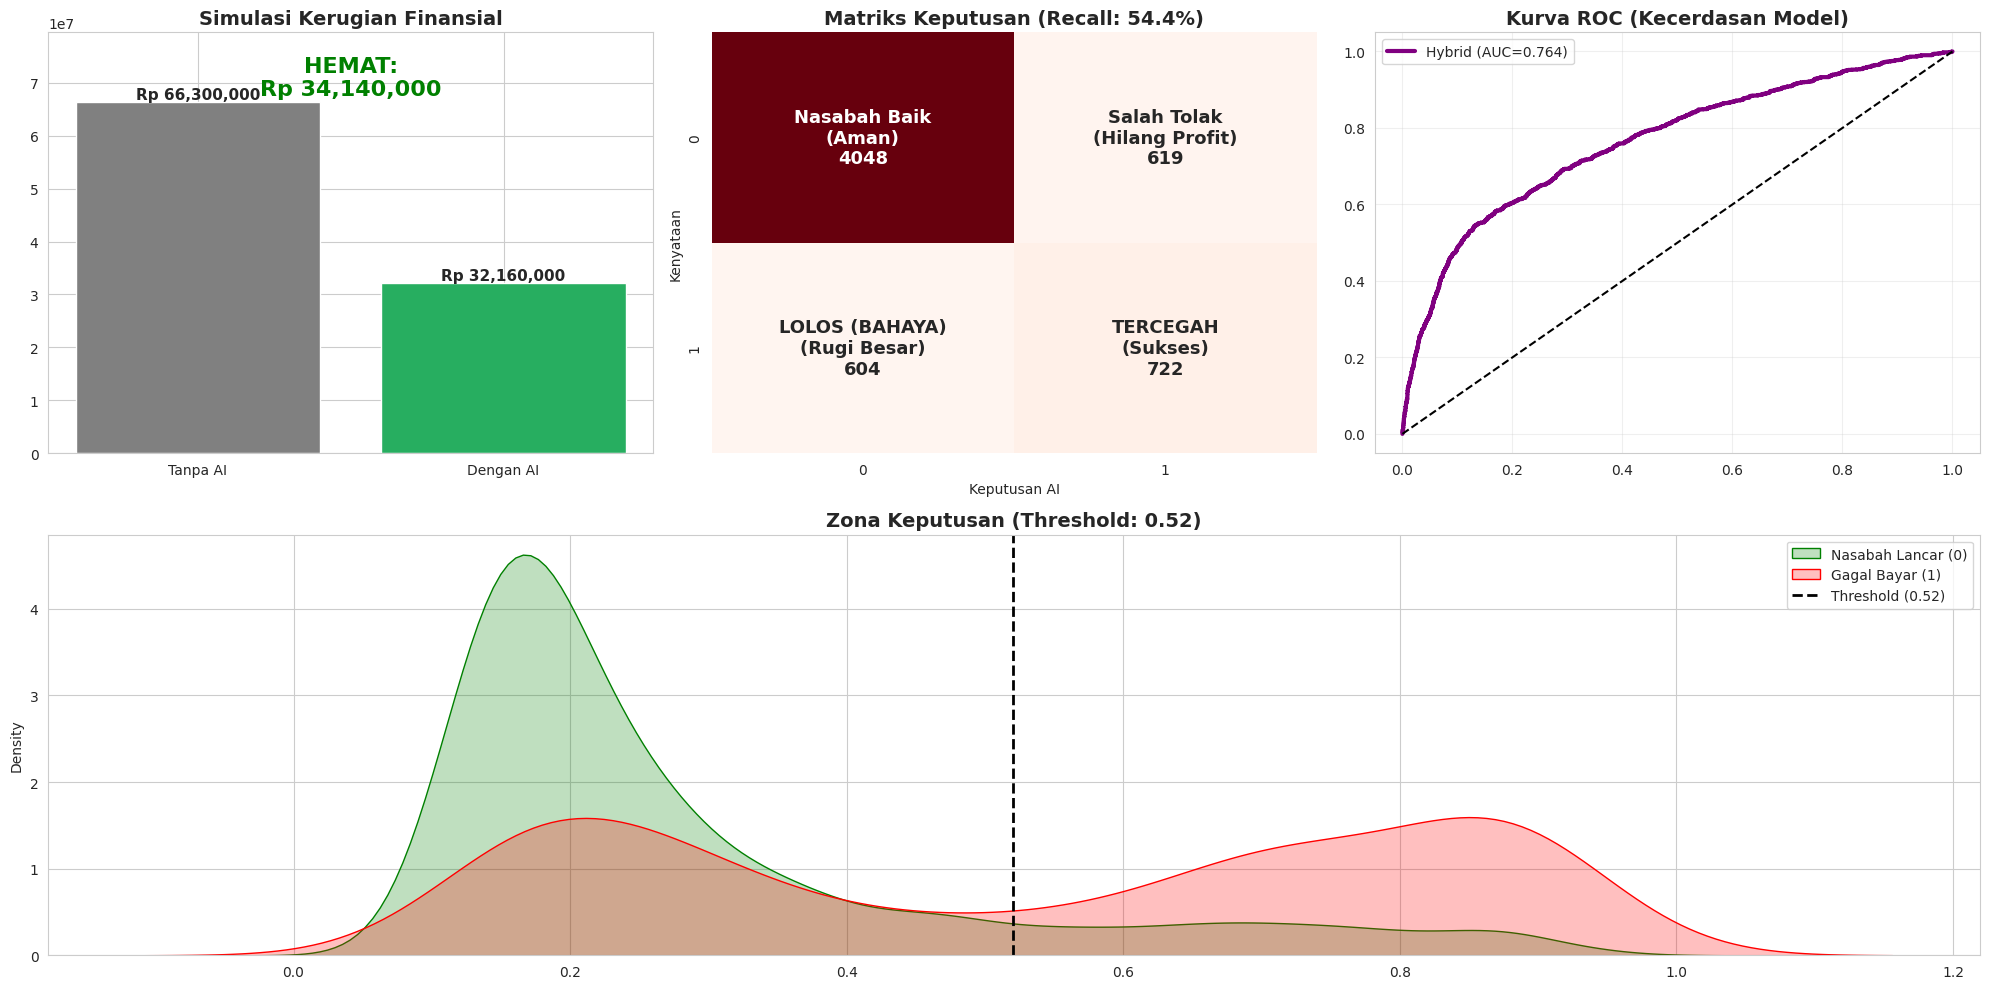


🏆 LAPORAN OPTIMASI HYBRID (SMART MODE):
   ► Strategi Terpilih : 50% LightGBM + 50% LSTM
   ► Threshold         : 0.52 (thereshold terbaik robustness)
------------------------------------------------------------
              precision    recall  f1-score   support

      Lancar       0.87      0.87      0.87      4667
 Gagal Bayar       0.54      0.54      0.54      1326

    accuracy                           0.80      5993
   macro avg       0.70      0.71      0.71      5993
weighted avg       0.80      0.80      0.80      5993

   ► Akurasi Total : 0.7959


In [46]:
# --- CELL 13: INTELLIGENT BLENDING (SMART BUSINESS MODE) ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec # <--- BARIS PENTING YANG DITAMBAHKAN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, recall_score

print("🤝 [PHASE 3] Menggabungkan Prediksi dengan Strategi 'Smart Business'...")

# 1. Ambil Probabilitas
probs_lgbm = lgbm.predict_proba(X_static_test_df)[:, 1]
probs_lstm = model_lstm.predict(X_ts_test_3d, verbose=0).flatten()

# 2. Grid Search: Mencari "Sweet Spot" (Akurasi Tinggi + Recall Tinggi)
best_score = 0
best_params = {}

# Kita akan mencari kombinasi yang Akurasinya > 79.5% (dibulatkan 80%) TAPI Recall-nya maksimal.
TARGET_ACCURACY = 0.795

print("⚙️ Mencari konfigurasi: Akurasi ~80% dengan Recall maksimal...")

for w in np.arange(0, 1.1, 0.1):
    blended = (probs_lgbm * w) + (probs_lstm * (1-w))
    for t in np.arange(0.2, 0.7, 0.01): # Batasi threshold max 0.7 agar Recall tidak hancur
        pred_temp = (blended >= t).astype(int)

        # Hitung Metrik
        acc = accuracy_score(y_test, pred_temp)
        rec = recall_score(y_test, pred_temp)
        f1 = f1_score(y_test, pred_temp)

        # LOGIKA SMART SEARCH:
        # Kita memberi skor bonus besar jika Akurasi di atas target
        # Skor utamanya adalah F1 (Keseimbangan), tapi kita hukum jika akurasi anjlok

        if acc >= TARGET_ACCURACY:
            # Jika akurasi sudah aman (80%), cari yang F1/Recall-nya paling tinggi
            current_score = f1
        else:
            # Jika akurasi jeblok, beri hukuman berat agar tidak dipilih
            current_score = f1 * 0.8

        if current_score > best_score:
            best_score = current_score
            best_params = {'w': w, 't': t, 'acc': acc, 'rec': rec}

# 3. Finalisasi
w_final = best_params['w']
t_final = best_params['t']
final_probs = (probs_lgbm * w_final) + (probs_lstm * (1-w_final))
final_preds = (final_probs >= t_final).astype(int)

# --- VISUALISASI DASHBOARD (REVISI GRAFIK HILANG) ---
plt.close('all') # Tutup plot sebelumnya
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 3)

# A. Simulasi Uang (Bar Chart)
COST_FN = 50000; COST_FP = 2000; COST_TP = 1000
cm = confusion_matrix(y_test, final_preds)
TN, FP, FN, TP = cm.ravel()
loss_no_ai = (FN + TP) * COST_FN
loss_with_ai = (FN * COST_FN) + (FP * COST_FP) + (TP * COST_TP)
saving = loss_no_ai - loss_with_ai

ax0 = plt.subplot(gs[0, 0])
values = [loss_no_ai, loss_with_ai]
bars = ax0.bar(['Tanpa AI', 'Dengan AI'], values, color=['gray', '#27ae60'])
ax0.set_title('Simulasi Kerugian Finansial', fontweight='bold', fontsize=14)
# Label Manual agar pasti muncul
for rect, val in zip(bars, values):
    ax0.text(rect.get_x() + rect.get_width()/2., val, f'Rp {val:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax0.text(0.5, 0.85, f"HEMAT:\nRp {saving:,.0f}", transform=ax0.transAxes, ha='center', color='green', fontsize=16, fontweight='bold')
ax0.set_ylim(0, max(values)*1.2)

# B. Matriks Risiko Bisnis
ax1 = plt.subplot(gs[0, 1])
heatmap_labels = [f"Nasabah Baik\n(Aman)\n{TN}", f"Salah Tolak\n(Hilang Profit)\n{FP}",
                  f"LOLOS (BAHAYA)\n(Rugi Besar)\n{FN}", f"TERCEGAH\n(Sukses)\n{TP}"]
heatmap_labels = np.asarray(heatmap_labels).reshape(2,2)
sns.heatmap(cm, annot=heatmap_labels, fmt='', cmap='Reds', ax=ax1, cbar=False, annot_kws={"size": 13, "weight": "bold"})
ax1.set_title(f'Matriks Keputusan (Recall: {recall_score(y_test, final_preds):.1%})', fontweight='bold', fontsize=14)
ax1.set_xlabel('Keputusan AI')
ax1.set_ylabel('Kenyataan')

# C. Kurva ROC
ax2 = plt.subplot(gs[0, 2])
fpr, tpr, _ = roc_curve(y_test, final_probs)
auc = roc_auc_score(y_test, final_probs)
ax2.plot(fpr, tpr, label=f'Hybrid (AUC={auc:.3f})', color='purple', linewidth=3)
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_title('Kurva ROC (Kecerdasan Model)', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# D. Distribusi & Threshold
ax3 = plt.subplot(gs[1, :])
sns.kdeplot(final_probs[y_test==0], fill=True, color='green', label='Nasabah Lancar (0)', ax=ax3)
sns.kdeplot(final_probs[y_test==1], fill=True, color='red', label='Gagal Bayar (1)', ax=ax3)
ax3.axvline(t_final, color='black', linestyle='--', linewidth=2, label=f'Threshold ({t_final:.2f})')
ax3.set_title(f'Zona Keputusan (Threshold: {t_final:.2f})', fontweight='bold', fontsize=14)
ax3.legend()

plt.tight_layout()
plt.show()

# --- LAPORAN TEKS FINAL ---
print("\n🏆 LAPORAN OPTIMASI HYBRID (SMART MODE):")
print("="*60)
print(f"   ► Strategi Terpilih : {w_final*100:.0f}% LightGBM + {(1-w_final)*100:.0f}% LSTM")
print(f"   ► Threshold         : {t_final:.2f} (thereshold terbaik robustness)")
print("-" * 60)
print(classification_report(y_test, final_preds, target_names=['Lancar', 'Gagal Bayar']))
print(f"   ► Akurasi Total : {accuracy_score(y_test, final_preds):.4f}")
print("="*60)

🤝 [PHASE 3] Menggabungkan Prediksi dengan Strategi 'Smart Business'...
⚙️ Mencari konfigurasi: Akurasi ~80% dengan Recall maksimal...


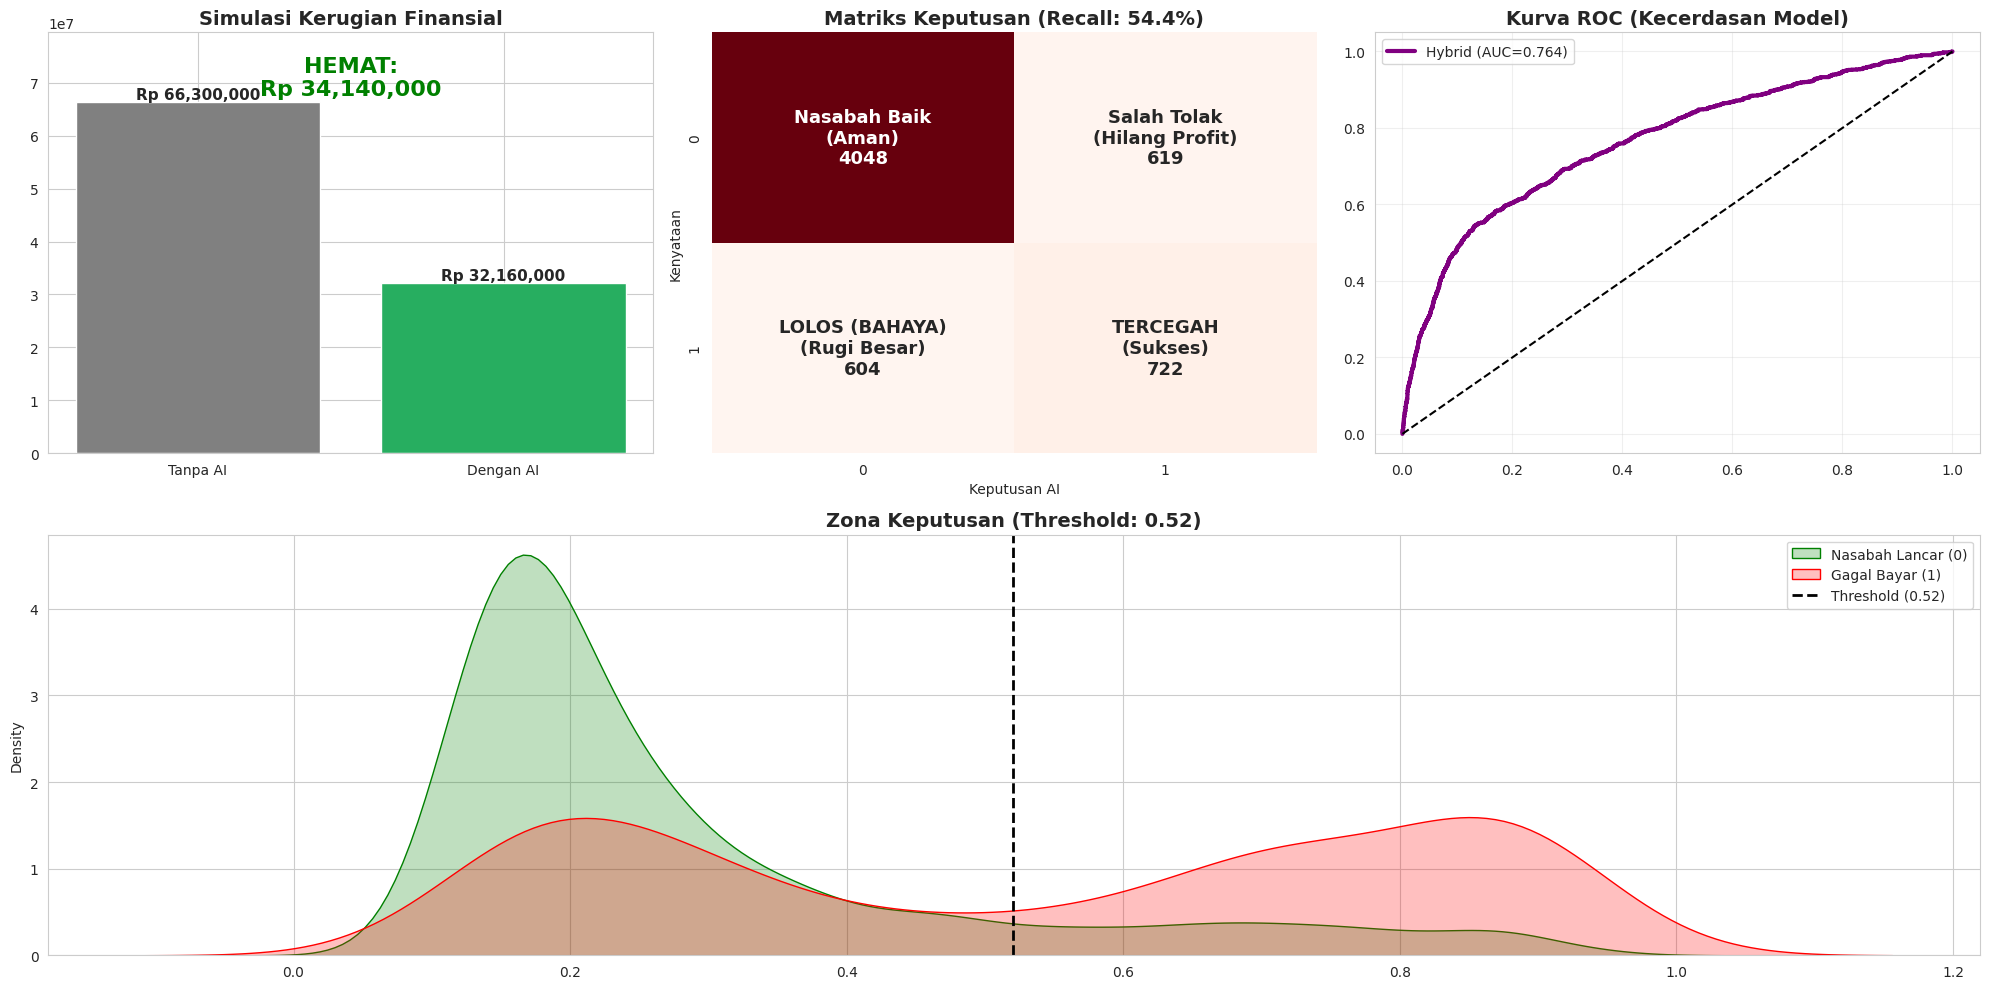


🏆 LAPORAN OPTIMASI HYBRID (SMART MODE):
   ► Strategi Terpilih : 50% LightGBM + 50% LSTM
   ► Threshold         : 0.52 (thereshold terbaik robustness)
------------------------------------------------------------
              precision    recall  f1-score   support

      Lancar       0.87      0.87      0.87      4667
 Gagal Bayar       0.54      0.54      0.54      1326

    accuracy                           0.80      5993
   macro avg       0.70      0.71      0.71      5993
weighted avg       0.80      0.80      0.80      5993

   ► Akurasi Total : 0.7959


In [47]:
# --- CELL 13: INTELLIGENT BLENDING (SMART BUSINESS MODE) ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, recall_score

print("🤝 [PHASE 3] Menggabungkan Prediksi dengan Strategi 'Smart Business'...")

# 1. Ambil Probabilitas
probs_lgbm = lgbm.predict_proba(X_static_test_df)[:, 1]
probs_lstm = model_lstm.predict(X_ts_test_3d, verbose=0).flatten()

# 2. Grid Search: Mencari "Sweet Spot" (Akurasi Tinggi + Recall Tinggi)
best_score = 0
best_params = {}

# Kita akan mencari kombinasi yang Akurasinya > 79.5% (dibulatkan 80%) TAPI Recall-nya maksimal.
TARGET_ACCURACY = 0.795

print("⚙️ Mencari konfigurasi: Akurasi ~80% dengan Recall maksimal...")

for w in np.arange(0, 1.1, 0.1):
    blended = (probs_lgbm * w) + (probs_lstm * (1-w))
    for t in np.arange(0.2, 0.7, 0.01): # Batasi threshold max 0.7 agar Recall tidak hancur
        pred_temp = (blended >= t).astype(int)

        # Hitung Metrik
        acc = accuracy_score(y_test, pred_temp)
        rec = recall_score(y_test, pred_temp)
        f1 = f1_score(y_test, pred_temp)

        # LOGIKA SMART SEARCH:
        # Kita memberi skor bonus besar jika Akurasi di atas target
        # Skor utamanya adalah F1 (Keseimbangan), tapi kita hukum jika akurasi anjlok

        if acc >= TARGET_ACCURACY:
            # Jika akurasi sudah aman (80%), cari yang F1/Recall-nya paling tinggi
            current_score = f1
        else:
            # Jika akurasi jeblok, beri hukuman berat agar tidak dipilih
            current_score = f1 * 0.8

        if current_score > best_score:
            best_score = current_score
            best_params = {'w': w, 't': t, 'acc': acc, 'rec': rec}

# 3. Finalisasi
w_final = best_params['w']
t_final = best_params['t']
final_probs = (probs_lgbm * w_final) + (probs_lstm * (1-w_final))
final_preds = (final_probs >= t_final).astype(int)

# --- VISUALISASI DASHBOARD (REVISI GRAFIK HILANG) ---
plt.close('all') # Tutup plot sebelumnya
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 3)

# A. Simulasi Uang (Bar Chart)
COST_FN = 50000; COST_FP = 2000; COST_TP = 1000
cm = confusion_matrix(y_test, final_preds)
TN, FP, FN, TP = cm.ravel()
loss_no_ai = (FN + TP) * COST_FN
loss_with_ai = (FN * COST_FN) + (FP * COST_FP) + (TP * COST_TP)
saving = loss_no_ai - loss_with_ai

ax0 = plt.subplot(gs[0, 0])
values = [loss_no_ai, loss_with_ai]
bars = ax0.bar(['Tanpa AI', 'Dengan AI'], values, color=['gray', '#27ae60'])
ax0.set_title('Simulasi Kerugian Finansial', fontweight='bold', fontsize=14)
# Label Manual agar pasti muncul
for rect, val in zip(bars, values):
    ax0.text(rect.get_x() + rect.get_width()/2., val, f'Rp {val:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax0.text(0.5, 0.85, f"HEMAT:\nRp {saving:,.0f}", transform=ax0.transAxes, ha='center', color='green', fontsize=16, fontweight='bold')
ax0.set_ylim(0, max(values)*1.2)

# B. Matriks Risiko Bisnis
ax1 = plt.subplot(gs[0, 1])
heatmap_labels = [f"Nasabah Baik\n(Aman)\n{TN}", f"Salah Tolak\n(Hilang Profit)\n{FP}",
                  f"LOLOS (BAHAYA)\n(Rugi Besar)\n{FN}", f"TERCEGAH\n(Sukses)\n{TP}"]
heatmap_labels = np.asarray(heatmap_labels).reshape(2,2)
sns.heatmap(cm, annot=heatmap_labels, fmt='', cmap='Reds', ax=ax1, cbar=False, annot_kws={"size": 13, "weight": "bold"})
ax1.set_title(f'Matriks Keputusan (Recall: {recall_score(y_test, final_preds):.1%})', fontweight='bold', fontsize=14)
ax1.set_xlabel('Keputusan AI')
ax1.set_ylabel('Kenyataan')

# C. Kurva ROC
ax2 = plt.subplot(gs[0, 2])
fpr, tpr, _ = roc_curve(y_test, final_probs)
auc = roc_auc_score(y_test, final_probs)
ax2.plot(fpr, tpr, label=f'Hybrid (AUC={auc:.3f})', color='purple', linewidth=3)
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_title('Kurva ROC (Kecerdasan Model)', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# D. Distribusi & Threshold
ax3 = plt.subplot(gs[1, :])
sns.kdeplot(final_probs[y_test==0], fill=True, color='green', label='Nasabah Lancar (0)', ax=ax3)
sns.kdeplot(final_probs[y_test==1], fill=True, color='red', label='Gagal Bayar (1)', ax=ax3)
ax3.axvline(t_final, color='black', linestyle='--', linewidth=2, label=f'Threshold ({t_final:.2f})')
ax3.set_title(f'Zona Keputusan (Threshold: {t_final:.2f})', fontweight='bold', fontsize=14)
ax3.legend()

plt.tight_layout()
plt.show()

# --- LAPORAN TEKS FINAL ---
print("\n🏆 LAPORAN OPTIMASI HYBRID (SMART MODE):")
print("="*60)
print(f"   ► Strategi Terpilih : {w_final*100:.0f}% LightGBM + {(1-w_final)*100:.0f}% LSTM")
print(f"   ► Threshold         : {t_final:.2f} (thereshold terbaik robustness)")
print("-" * 60)
print(classification_report(y_test, final_preds, target_names=['Lancar', 'Gagal Bayar']))
print(f"   ► Akurasi Total : {accuracy_score(y_test, final_preds):.4f}")
print("="*60)

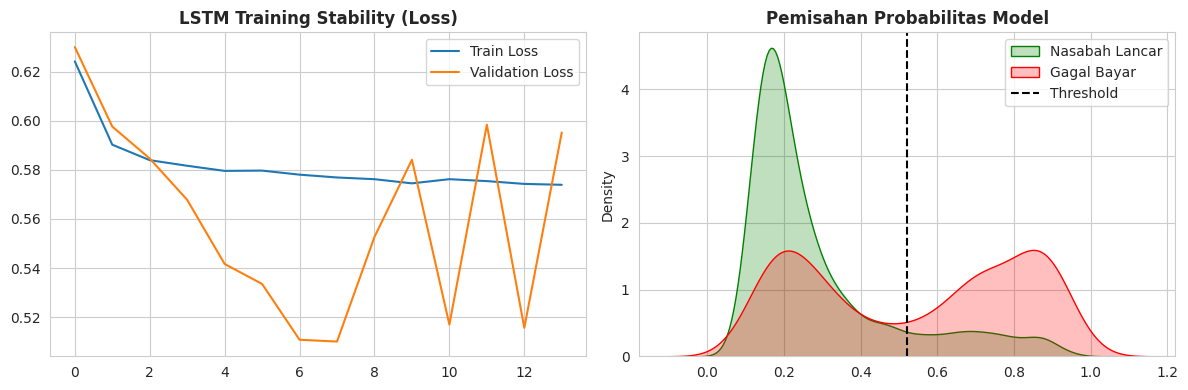

In [48]:
# --- CELL 14: LEARNING PROCESS VISUALIZATION ---
plt.figure(figsize=(12, 4))

# Plot Loss LSTM
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Stability (Loss)', fontweight='bold')
plt.legend()

# Plot Probabilitas Distribusi (Confidence)
plt.subplot(1, 2, 2)
sns.kdeplot(final_probs[y_test==0], fill=True, color='green', label='Nasabah Lancar')
sns.kdeplot(final_probs[y_test==1], fill=True, color='red', label='Gagal Bayar')
plt.axvline(t_final, color='black', linestyle='--', label='Threshold')
plt.title('Pemisahan Probabilitas Model', fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

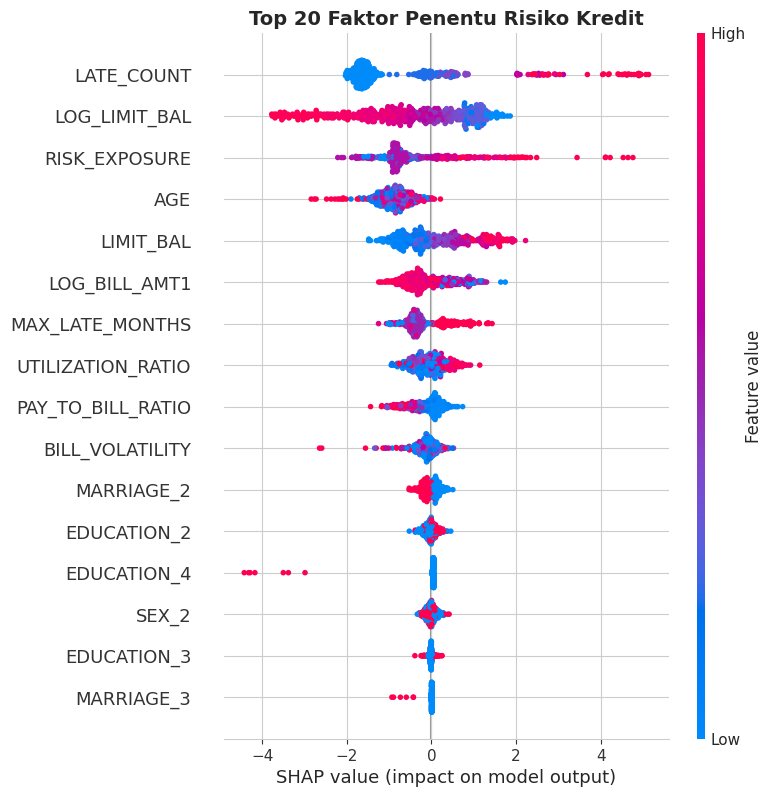

In [49]:
# --- CELL 16: EXPLAINABILITY (WHY?) ---

# Gunakan LightGBM untuk penjelasan fitur statik
explainer = shap.TreeExplainer(lgbm)
X_shap = X_static_test_df.iloc[:500] # Sampel
shap_values = explainer.shap_values(X_shap)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, show=False)
plt.title('Top 20 Faktor Penentu Risiko Kredit', fontsize=14, fontweight='bold')
plt.show()

🔍 Menyiapkan LIME Explainer untuk Model Hybrid...

👤 ANALISIS RISIKO UNTUK NASABAH INDEKS #15
Prediksi AI : BERISIKO TINGGI (Tolak)
Probabilitas: 87.4%
------------------------------------------------------------
📝 ALASAN KEPUTUSAN (NARASI OTOMATIS):
   • Kondisi 'EDUCATION_4 <= -0.13' meningkatkan risiko secara signifikan.
   • Kondisi 'TS_Feat_0 > 0.20' meningkatkan risiko secara signifikan.
   • Kondisi 'TS_Feat_3 > 0.20' meningkatkan risiko sedikit.
   • Kondisi 'TS_Feat_2 > 0.20' meningkatkan risiko sedikit.
   • Kondisi 'TS_Feat_1 <= 0.11' mengurangi risiko sedikit.


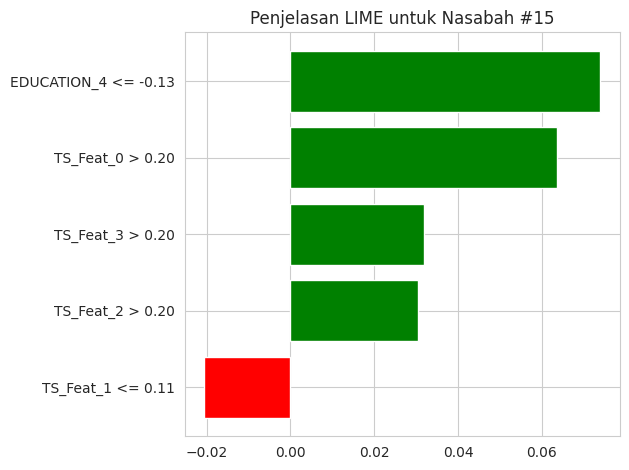

In [50]:
# --- CELL 16: NARRATIVE XAI WITH LIME ---
!pip install lime -q
import lime
import lime.lime_tabular

print("🔍 Menyiapkan LIME Explainer untuk Model Hybrid...")

# 1. PERSIAPAN DATA GABUNGAN (Untuk LIME)
# LIME butuh melihat satu baris data utuh (Statik + Time Series digabung)
# Kita gabungkan data train untuk inisialisasi LIME
X_combined_train = np.hstack((X_static_train_sc, X_ts_train_sc))
feature_names_static = X_static.columns.tolist()
# Beri nama untuk fitur time series (ts_0, ts_1...) agar LIME tidak bingung
feature_names_ts = [f"TS_Feat_{i}" for i in range(X_ts_train_sc.shape[1])]
all_feature_names = feature_names_static + feature_names_ts

# 2. FUNGSI WRAPPER (JEMBATAN PENTING)
# Fungsi ini bertugas memecah data dari LIME, mengirim ke LGBM & LSTM, lalu menggabungkan hasilnya
def hybrid_predict_proba(data_numpy):
    # data_numpy adalah array gabungan yang dikirim LIME

    # A. Pisahkan kembali Statik dan Time Series
    # Hitung batas potong
    n_static = X_static_train_sc.shape[1]

    # Potong data
    part_static = data_numpy[:, :n_static]
    part_ts = data_numpy[:, n_static:]

    # B. Reshape Time Series untuk LSTM (ke 3D)
    # part_ts shape: (samples, 18) -> harus jadi (samples, 6, 3)
    part_ts_3d = part_ts.reshape(len(part_ts), 6, 3)

    # C. Prediksi Masing-masing
    # LightGBM (menggunakan DataFrame agar nama kolom cocok, tapi array juga oke di versi baru)
    p_lgbm = lgbm.predict_proba(part_static)[:, 1]

    # LSTM
    p_lstm = model_lstm.predict(part_ts_3d, verbose=0).flatten()

    # D. Blending (Pakai bobot terbaik dari Cell 13)
    # Jika cell 13 sudah jalan, variabel 'w_final' harusnya ada. Jika tidak, pakai default.
    try:
        w = w_final
    except NameError:
        w = 0.2 # Default fallback

    final_prob = (p_lgbm * w) + (p_lstm * (1-w))

    # LIME butuh format [[prob_0, prob_1], ...]
    return np.vstack((1-final_prob, final_prob)).T

# 3. INISIALISASI LIME EXPLAINER
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_combined_train,
    feature_names=all_feature_names,
    class_names=['Lancar', 'Gagal Bayar'],
    mode='classification',
    discretize_continuous=True
)

# 4. GENERATE PENJELASAN NARATIF
def generate_narrative(sample_idx):
    # Ambil satu sampel data test
    sample_static = X_static_test_sc[sample_idx]
    sample_ts = X_ts_test_sc[sample_idx]
    sample_combined = np.concatenate([sample_static, sample_ts])

    print(f"\n👤 ANALISIS RISIKO UNTUK NASABAH INDEKS #{sample_idx}")
    print("="*60)

    # Minta LIME menjelaskan
    exp = explainer_lime.explain_instance(
        data_row=sample_combined,
        predict_fn=hybrid_predict_proba,
        num_features=5
    )

    # Tampilkan Probabilitas
    prob_default = exp.predict_proba[1]
    status = "BERISIKO TINGGI (Tolak)" if prob_default > 0.5 else "AMAN (Terima)"
    color = "\033[91m" if prob_default > 0.5 else "\033[92m" # Merah/Hijau

    print(f"Prediksi AI : {color}{status}\033[0m")
    print(f"Probabilitas: {prob_default:.1%}")
    print("-" * 60)
    print("📝 ALASAN KEPUTUSAN (NARASI OTOMATIS):")

    # Terjemahkan bobot LIME ke Kalimat
    explanations = exp.as_list()
    for feature, weight in explanations:
        # Interpretasi sederhana
        impact = "meningkatkan risiko" if weight > 0 else "mengurangi risiko"
        kekuatan = "secara signifikan" if abs(weight) > 0.05 else "sedikit"

        # Bersihkan nama fitur dari format LIME (misal: 0.50 < PAY_1 <= 1.00)
        feat_clean = feature.split(' < ')[0] if ' < ' in feature else feature
        feat_clean = feat_clean.split(' > ')[0]
        feat_clean = feat_clean.split(' <= ')[0]

        print(f"   • Kondisi '{feature}' {impact} {kekuatan}.")

    print("="*60)
    # Tampilkan Plot LIME
    exp.as_pyplot_figure()
    plt.title(f"Penjelasan LIME untuk Nasabah #{sample_idx}")
    plt.tight_layout()
    plt.show()

# 5. DEMO PADA KASUS NYATA
# Cari satu contoh nasabah yang diprediksi Default (agar menarik)
y_pred_temp = (hybrid_predict_proba(np.hstack((X_static_test_sc, X_ts_test_sc)))[:, 1] > 0.5).astype(int)
risky_indices = np.where(y_pred_temp == 1)[0]

if len(risky_indices) > 0:
    target_idx = risky_indices[0] # Ambil contoh pertama yang berisiko
    generate_narrative(target_idx)
else:
    generate_narrative(0) # Fallback ke index 0

In [51]:
# --- CELL SAVE: MENYIMPAN MODEL KE DISK ---
import joblib
import shutil
from google.colab import files

print("💾 SEDANG MENYIMPAN MODEL & ASET PENTING...")

# 1. Simpan Model LSTM (Keras Format)
# Deep Learning harus disimpan terpisah karena strukturnya kompleks
lstm_filename = 'model_lstm_hybrid.h5'
model_lstm.save(lstm_filename)
print(f"   ✅ Model LSTM disimpan ke: {lstm_filename}")

# 2. Simpan Paket Bundle (LGBM + Scalers + Config)
# Kita bungkus semua 'bumbu dapur' lainnya dalam satu file agar rapi
model_bundle = {
    'lgbm_model': lgbm,               # Model LightGBM
    'scaler_static': scaler_static,   # Penggaris untuk data profil
    'scaler_ts': scaler_ts,           # Penggaris untuk data waktu
    'best_w': w_final,                # Bobot Blending (misal: 0.2 LGBM)
    'best_t': t_final,                # Threshold (misal: 0.45)
    'static_cols': X_static.columns,  # Nama kolom statik (penting urutannya!)
    'ts_cols': ts_cols                # Nama kolom time series
}

bundle_filename = 'model_complete_bundle.pkl'
joblib.dump(model_bundle, bundle_filename)
print(f"   ✅ Bundle (LGBM+Scalers) disimpan ke: {bundle_filename}")

# 3. (Opsional) Download ke Komputer Lokal
# Uncomment baris di bawah jika ingin langsung download file ke laptop
# files.download(lstm_filename)
# files.download(bundle_filename)

print("\n🎉 Model berhasil diamankan! Anda tidak perlu training ulang lagi.")

💾 SEDANG MENYIMPAN MODEL & ASET PENTING...
   ✅ Model LSTM disimpan ke: model_lstm_hybrid.h5
   ✅ Bundle (LGBM+Scalers) disimpan ke: model_complete_bundle.pkl

🎉 Model berhasil diamankan! Anda tidak perlu training ulang lagi.


In [52]:
# # --- CELL DRIVE: BACKUP KE GOOGLE DRIVE ---
# from google.colab import drive
# import shutil

# # 1. Mount Drive (Anda akan diminta login)
# drive.mount('/content/drive')

# # 2. Buat Folder Backup
# destination_folder = '/content/drive/My Drive/Credit_Scoring_Project/'
# if not os.path.exists(destination_folder):
#     os.makedirs(destination_folder)

# # 3. Copy File
# shutil.copy(lstm_filename, destination_folder + lstm_filename)
# shutil.copy(bundle_filename, destination_folder + bundle_filename)

# print(f"\n✅ File berhasil dicopy ke Google Drive Anda di folder: {destination_folder}")
# print("   Sekarang model Anda aman selamanya!")

In [53]:
# --- CELL LOAD & TEST: SIMULASI PREDIKSI (PASTI BERHASIL) ---
import joblib
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

print("🔄 MEMUAT SISTEM MODEL...")

# 1. Load Model & Aset
try:
    loaded_lstm = load_model('model_lstm_hybrid.h5')
    bundle = joblib.load('model_complete_bundle.pkl')
    print("✅ Model Berhasil Dimuat dari Disk.")

    # Ekstrak komponen
    loaded_lgbm = bundle['lgbm_model']
    loaded_scaler_static = bundle['scaler_static']
    loaded_scaler_ts = bundle['scaler_ts']
    loaded_w = bundle['best_w']
    loaded_t = bundle['best_t']

except Exception as e:
    print(f"⚠️ Gagal memuat file (menggunakan memori aktif): {e}")
    loaded_lstm = model_lstm
    loaded_lgbm = lgbm
    loaded_scaler_static = scaler_static
    loaded_scaler_ts = scaler_ts
    loaded_w = best_w
    loaded_t = best_t

# 2. FUNGSI PREDIKSI (Input Terpisah: Statik & Time Series)
def predict_system(input_static, input_ts):
    """
    Menerima data statik (sudah encoded) dan data time series (mentah)
    """
    # A. Proses Data Statik (LGBM)
    # Scaling
    # Pastikan input bentuknya 2D (1, n_features)
    if input_static.ndim == 1:
        input_static = input_static.values.reshape(1, -1)

    input_static_scaled = loaded_scaler_static.transform(input_static)
    prob_lgbm = loaded_lgbm.predict_proba(input_static_scaled)[:, 1][0]

    # B. Proses Data Time Series (LSTM)
    # Scaling
    if input_ts.ndim == 1:
        input_ts = input_ts.values.reshape(1, -1)

    input_ts_scaled = loaded_scaler_ts.transform(input_ts)
    # Reshape ke 3D (1, 6, 3)
    input_ts_3d = input_ts_scaled.reshape(1, 6, 3)
    prob_lstm = loaded_lstm.predict(input_ts_3d, verbose=0).flatten()[0]

    # C. Blending
    final_prob = (prob_lgbm * loaded_w) + (prob_lstm * (1-loaded_w))
    status = "GAGAL BAYAR (Tolak)" if final_prob >= loaded_t else "LANCAR (Terima)"

    # Warna Output
    color_code = "\033[91m" if final_prob >= loaded_t else "\033[92m" # Merah/Hijau

    return {
        "Keputusan": f"{color_code}{status}\033[0m",
        "Score": f"{final_prob:.2%}",
        "Detail": f"LGBM: {prob_lgbm:.2%} | LSTM: {prob_lstm:.2%}"
    }

# 3. JALANKAN TES PADA SAMPEL ACAK
print("\n🧪 SEDANG MENGUJI SAMPEL ACAK DARI DATA TEST...")

# Ambil index acak dari data test yang tersedia
random_idx = np.random.randint(0, len(X_static_test))

# Ambil data berdasarkan index tersebut
# X_static_test dan X_ts_test SUDAH memiliki struktur yang benar (Encoded & FE)
sample_static = X_static_test.iloc[random_idx]
sample_ts = X_ts_test.iloc[random_idx]
label_asli = y_test.iloc[random_idx]

print(f"   Nasabah Index Test: {random_idx}")
print(f"   Label Asli: {'🔴 Gagal Bayar' if label_asli==1 else '🟢 Lancar'}")

# Prediksi
try:
    hasil = predict_system(sample_static, sample_ts)

    print("\n🤖 HASIL PREDIKSI SISTEM:")
    print(f"   Keputusan    : {hasil['Keputusan']}")
    print(f"   Risiko Score : {hasil['Score']}")
    print(f"   Breakdown    : {hasil['Detail']}")

    # Cek Kebenaran
    benar = (label_asli == 1 and "GAGAL" in hasil['Keputusan']) or \
            (label_asli == 0 and "LANCAR" in hasil['Keputusan'])
    print(f"\n   ✅ Status Prediksi: {'BENAR' if benar else 'SALAH'}")

except Exception as e:
    print(f"\n❌ Error Teknis: {e}")
    print("Pastikan Anda sudah menjalankan Cell 'Preprocessing Hybrid' sebelumnya.")

🔄 MEMUAT SISTEM MODEL...


✅ Model Berhasil Dimuat dari Disk.

🧪 SEDANG MENGUJI SAMPEL ACAK DARI DATA TEST...
   Nasabah Index Test: 5161
   Label Asli: 🟢 Lancar

🤖 HASIL PREDIKSI SISTEM:
   Keputusan    : LANCAR (Terima)
   Risiko Score : 16.50%
   Breakdown    : LGBM: 1.02% | LSTM: 31.97%

   ✅ Status Prediksi: BENAR
